<a href="https://colab.research.google.com/github/albanda/CE888/blob/master/lab7/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CE888 Lab 7
Dr Ana Matran-Fernandez,  University of Essex.

## Training a CNN Classifier

- Lab Objective: Create, train, and test a CNN model

### Instructions: 

1. Go through each code block,
 study and make sure you understand each of them,
 and fill in the missing "TODO" parts.

2. Save a neural network for the MNIST dataset and run it as an attachment through the Moodle CE888 Lab 7 quiz.

3. Save a neural network for the Cifar10 dataset and run it as an attachment through the Moodle CE888 Lab 7 quiz.

4. If you have time, work through the "checklist of things to do" in the final block of this page.

Before you start (if you're running this locally; this is not necessary on Colab):
- Check you have the python packages numpy, matplotlib, tensorflow.
- e.g., install them with "pip3 install numpy, matplotlib, tensorflow"

Acknowledgements:
- This lab session is based on Dr Michael Fairbank's CE811 materials.


~~and the lab answer is based on the answer I produced for that lab in ce811 :^)~~

In [1]:
import sys
import subprocess
import pkg_resources

required = {"numpy","tensorflow","matplotlib<=3.5.1",}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    sys.stderr.write(f"ERROR: Missing the following required packages:\n{missing}\n")
    sys.stderr.write("Attempting to install missing dependencies to user directory\n")
    sys.stderr.flush()
    python = sys.executable
    try:
        subprocess.check_call([python, "-m", "pip","install",*missing,"--user","--force-reinstall"], stdout=subprocess.DEVNULL)
        sys.stdout.write("okay it installed correctly on --user\n",flush=True)
    except Exception:
        sys.stderr.write("Could not perform a --user install, trying an install that is not --user\n")
        sys.stderr.flush()
        try:
            subprocess.check_call([python, "-m", "pip","install",*missing,"--force-reinstall"], stdout=subprocess.DEVNULL)
            sys.stdout.write("installed successfully, everything should work now\n",flush=True)
        except Exception:
            sys.stderr.write("okay looks like we couldn't download it, so this notebook might not work, but don't say I didn't try to get it to work!\n")
            sys.stderr.flush()


ERROR: Missing the following required packages:
{'matplotlib<=3.5.1'}
Attempting to install missing dependencies to user directory
Could not perform a --user install, trying an install that is not --user
okay looks like we couldn't download it, so this notebook might not work, but don't say I didn't try to get it to work!


In [2]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#import mpl_toolkits.mplot3d
#print(mpl_toolkits.mplot3d.__file__)



import matplotlib
import matplotlib.pyplot as plt



print(matplotlib.__version__)

""

3.5.1


''

In [3]:


print(matplotlib.__version__)

3.5.1


In [4]:
print(plt)

<module 'matplotlib.pyplot' from '/ufs/servg00/users/rl18730/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>


## Load a vision benchmark dataset

- We will start with the MNIST hand-written numeric digits dataset.


In [5]:
dataset_name = "mnist"

if dataset_name == "cifar10":
    dataset = tf.keras.datasets.cifar10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
    # CIFAR10 images are 32*32*3.
    accuracy_threshold = 0.6  # Moodle progress checker expects >60% accuracy on CIFAR10
elif dataset_name == "fashion":
    dataset = tf.keras.datasets.fashion_mnist
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    accuracy_threshold = 0.8
elif dataset_name == "mnist":
    accuracy_threshold = 0.96  # Moodle progress checker expects >96% accuracy on MNIST.
    dataset = tf.keras.datasets.mnist
    class_names = ['zero', 'one', 'two', 'three', 'four','five', 'six', 'seven', 'eight', 'nine']
else:
    print("unknown dataset")
    raise Exception("Please specify a valid dataset!")

(train_images0, train_labels0), (test_images0, test_labels0) = dataset.load_data()

print('Train: X=%s, y=%s' % (train_images0.shape, train_labels0.shape))
print('Test: X=%s, y=%s' % (test_images0.shape, test_labels0.shape))

train_labels = train_labels0.reshape(-1)
test_labels = test_labels0.reshape(-1)


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


## Visualise the Dataset

- Show a few pictures of the images we are trying to learn from...

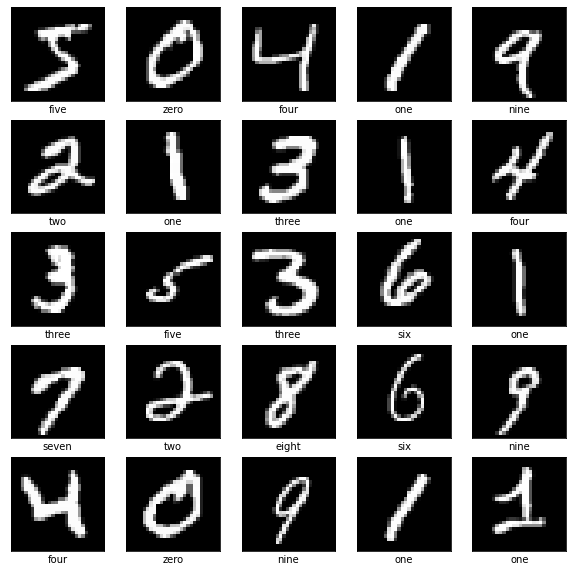

In [6]:
# plot a few images
plt.figure(figsize=(10,10))
for i in range(25):
    # define subplot
    plt.subplot(5,5,i+1)
    # plot raw pixel data
    plt.imshow(
        train_images0[i],
        cmap=plt.get_cmap('gray')
    )
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if class_names is not None:
        # Add a label underneath, if we have one...
        plt.xlabel(class_names[train_labels[i]])
plt.show()

## Prep the data
- The keras datasets contain integer pixel intensities from 0 to 255.  We must rescale this to floats from 0 to 1.

In [7]:
# Rescale greyscale from 8 bit to floating point (by dividing by 255)
test_images = (test_images0 / 255.0).astype(np.float32) # 10000 test patterns, shape 10000*28*28  
train_images = (train_images0 / 255.0).astype(np.float32) # 60000 train patterns, shape 60000*28*28

if len(train_images.shape) == 3:  # images must be rank-4 tensors [number_of_images, dimension1, dimension2, number_of_channels]
    # add a single channel to these black-and-white images
    train_images=train_images.reshape(list(train_images.shape)+[1])
    test_images=test_images.reshape(list(test_images.shape)+[1])
    print("Reshaped images from ", train_images0.shape, "to", train_images.shape, "so that 'channel' dimension exists")

num_classification_categories = train_labels.max() + 1


Reshaped images from  (60000, 28, 28) to (60000, 28, 28, 1) so that 'channel' dimension exists


## Define a model
- This means build our neural network here.
- TODO modify the simple model defined below
 so that it has the following structure.
- Use relu activation functions everywhere,
 except for the last layer which must have a softmax activation function.
- Use kernel size (3, 3) for each convolutional layer
 and pool size (2, 2) for each max-pooling layer.
 Ensure you obtain the architecture exactly as shown here...

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
layer1 (Conv2D)              (None, 28, 28, 6)         60
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 14, 14, 6)         0
_________________________________________________________________
layer3 (Conv2D)              (None, 14, 14, 3)         165
_________________________________________________________________
layer4 (MaxPooling2D)        (None, 7, 7, 3)           0
_________________________________________________________________
layer5 (Flatten)             (None, 147)               0
_________________________________________________________________
layer6 (Dense)               (None, 128)               18944
_________________________________________________________________
layer7 (Dense)               (None, 10)                1290
=================================================================
Total params: 20,459
Trainable params: 20,459
Non-trainable params: 0
_________________________________________________________________

```


In [8]:

# build model with CNN architecture

# YOUR CODE HERE (no need to specify the input shape in the first layer)
model_a = keras.Sequential()
model_a.add(
    layers.Conv2D(filters=6, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")
)
model_a.add(
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid")
)
model_a.add(
    layers.Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")
)
model_a.add(
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid")
)

model_a.add(layers.Flatten())
model_a.add(layers.Dense(128, activation='relu'))
model_a.add(layers.Dense(num_classification_categories, activation='softmax'))


## View Model Summary

- Have a look at the model summary here and compare with the output above to make sure they're the same.

In [9]:
model_a.build(input_shape=(None,) + train_images.shape[1:])
model_a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 3)         165       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 3)           0         
_________________________________________________________________
flatten (Flatten)            (None, 147)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               18944     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [10]:
if model_a.count_params() > 800000 and dataset_name == "cifar10":
    print("The lab7 quiz has a 10MB limit on your model size, so use a smaller model if you want to validate through the auto-marker!")

## Train the network

In [11]:
optimizer = keras.optimizers.Adam()

model_a.compile(optimizer=optimizer,
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

history = model_a.fit(train_images, train_labels,
                batch_size=128,
                epochs=5,
                validation_data=(test_images, test_labels))


Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.4878 - accuracy: 0.8577 - val_loss: 0.2036 - val_accuracy: 0.9406

## Plot graphs of learning progress...

- Have a look at these graphs, and try to work out whether any
 overfitting has occurred, or whether we would gain any benefit
 from training for more or fewer epochs (TODO)

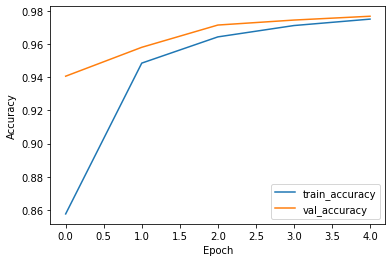

In [12]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Inspect how well the system is working...
- The test set has a lot of images in it,
 but we can only view 25 at a time.
- Hence rerun this code block several times,
 to get a different random set of samples from the test set (TODO)


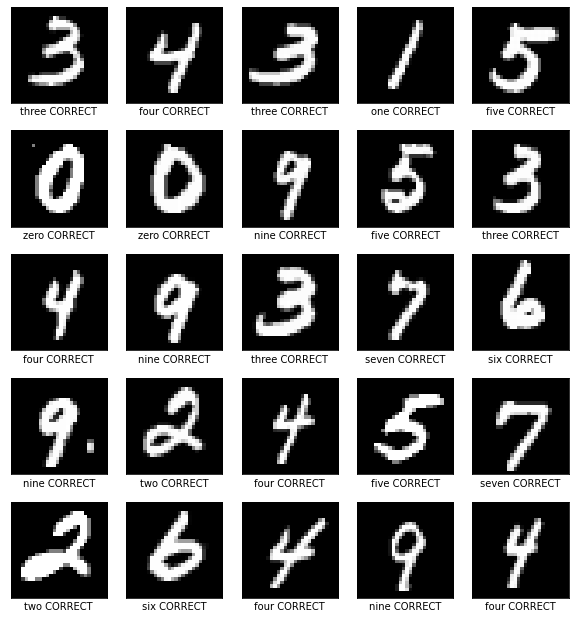

In [13]:
plt.figure(figsize=(10,11))
# plot 25 random images from the test set.
first_index = np.random.randint(len(test_images)-25)
for i in range(first_index,first_index+25):
    # define subplot
    plt.subplot(5,5,i+1-first_index)
    # plot raw pixel data
    plt.imshow(test_images0[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if class_names is not None:
        # Add a label underneath, if we have one...
        prediction = model_a(test_images[i:i+1])[0,:]
        prediction_class = np.argmax(prediction)
        true_label = test_labels[i]
        class_name = class_names[prediction_class]
        plt.xlabel(class_name+" "+("CORRECT" if prediction_class==true_label else "WRONG\n{}".format(class_names[true_label])))
plt.subplots_adjust(hspace=0.2)
plt.show()

## Save the model
- Once you have the correct layers created (as described above)
 and have trained a model which can score >96% on the
 MNIST digits validation set, save your model with the next code block.
- Then use your saved model as an attachment to pass questions 1+2 of
 the Lab 7 Quiz on Moodle.

In [14]:
if history.history["val_accuracy"][-1] > accuracy_threshold:
    print("Your model is accurate enough!")
    # Save the model into a local folder
    keras.models.save_model(model_a, "Model1"+dataset_name+".h5",save_format='h5')
else:
    print("Accuracy is below the threshold!")
    raise Exception("Your model isn't accurate enough to pass the progress checker!")

Your model is accurate enough!


# Attempting to visualize the kernels/features in the model

Using code lovingly nicked from https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [15]:
from typing import List, Tuple

def visualize_filters(conv_layer: layers.Conv2D) -> plt.Figure:
    """
    Attempts to visualize the filters from a particular conv2d layer of a CNN
    :param conv_layer: the conv2D layer we're trying to visualize the filters for
    :return: a matplotlib plot with visualizations of the conv layer on it.
    """
    filters, biases = conv_layer.get_weights()
    channels_in: int = conv_layer.input_shape[-1 if conv_layer.data_format=="channels_last" else 0]
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min)/(f_max-f_min)
    filter_count = conv_layer.filters

    if channels_in == 1:

        fig, axes = plt.subplots(nrows=channels_in, ncols=filter_count, figsize=(filter_count * 3, channels_in * 3))
        for i in range(filter_count):
            f = filters[:, :, :, i]
            ax: plt.Subplot = axes[i]
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(f, cmap="gray")
    else:
        fig: plt.Figure = plt.figure(
            constrained_layout=True,
            figsize=(filter_count*3, channels_in*3)
        )
        subfigs = fig.subfigures(nrows=channels_in, ncols=1, hspace=0.1)
        for row, subfig in enumerate(subfigs):
            subfig.suptitle("Filters for channel {}".format(row))
            axes = subfig.subplots(nrows=1, ncols=filter_count)
            for col, ax in enumerate(axes):
                f = filters[:, :, :, col]
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(f[:,:,row], cmap="gray")

    #for i in range(filter_count):
    #    f = filters[:, :, :, i]
    #    for j in range(channels_in):
    #        ax: plt.Subplot = axes[i] if channels_in == 1 else axes[i, j]
    #        ax.set_xticks([])
    #        ax.set_yticks([])
    #        ax.imshow(f[:,:,j], cmap="gray")
    return fig


def show_filters_auto_title(layer: keras.layers.Conv2D, layer_num: int, title_text: str = "Layer {} filter kernels") -> plt.Figure:
    """
    Wrapper for the above method but automatically puts a title on the figure produced
    :param layer: the actual layer that's being visualized
    :param layer_num: what layer number is this?
    :param title_text: placeholder text for a title. Default value is "Layer {} filter kernels", {} will be replaced by layer_num
    :return: matplotlib figure showing the kernels for each channel in the layer, along with a title on it.
    """
    f: plt.Figure = visualize_filters(layer)
    f.suptitle(title_text.format(layer_num))
    return f


def show_filters_for_layers_auto_title(model: keras.Model, layers_to_show: List[int] = None, title_text: str = "Layer {} filter kernels") -> List[plt.Figure]:
    """
    Wrapper for show_filters_auto_title but for certain preselected layers of the model
    :param model: the model that's being visualized
    :param layers_to_show: indices of the layers to be shown. If not specified, will show all conv2D layers
    :param title_text: placeholder title text for each figure.
    :return: a list of figures showing the kernel filters for each channel for each conv2D layer in the CNN
    """
    if layers_to_show is None:
        layers_to_show: List[int] = list(l for l in range(len(model.layers)) if isinstance(model.layers[l], keras.layers.Conv2D))

    return list(
        show_filters_auto_title(model.layers[i], i, title_text) for i in layers_to_show
    )



<ipython-input-16-cdb865a45748>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  l0_fig.show()


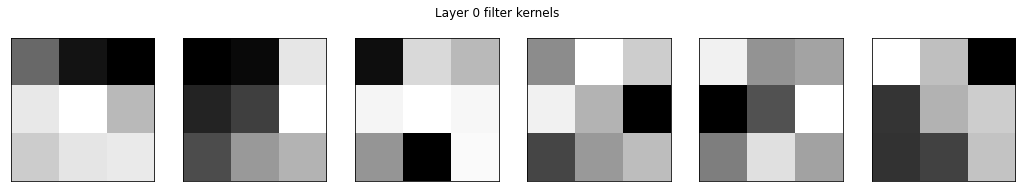

In [16]:
import traceback

try:
    l0_fig = visualize_filters(model_a.layers[0])
    l0_fig.suptitle("Layer 0 filter kernels")
    l0_fig.show()
except Exception as e:
    print("cannot show layer 0 filter kernels.")
    print("reason: ")
    print(traceback.format_exc())

<ipython-input-17-e833a5d5eb76>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  l2_fig.show()


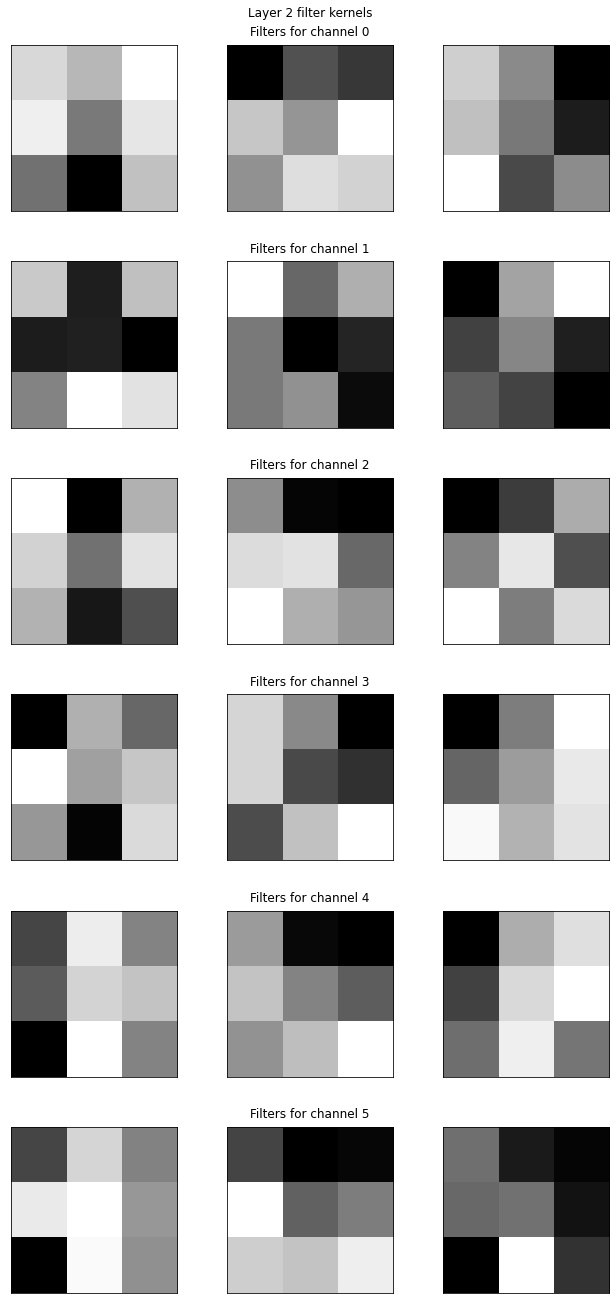

In [17]:
try:
    l2_fig = visualize_filters(model_a.layers[2])
    l2_fig.suptitle("Layer 2 filter kernels")
    l2_fig.show()
except Exception as e:
    print("cannot show layer 2 filter kernels.")
    print("reason: ")
    print(traceback.format_exc())

In [18]:
import math

def show_feature_maps(original_model: keras.Model, images: np.ndarray) -> List[plt.Figure]:
    """
    Attempts to show the feature maps produced by the conv2d layers in the given model.
    :param original_model: the model we're testing.
    :param images: the image(s) we're feeding it as inputs.
    Needs to be of a shape that is accepted as an input by the original_model.
    If a batch of multiple images is provided, it will automatically slice it to get only a single image.
    :return: a list of matplotlib figures, each of which are showing the feature maps
    produced by each conv2d layer.
    """

    if not any(isinstance(layer, keras.layers.Conv2D) for layer in original_model.layers):
        return []

    extractor = keras.Model(
        inputs=original_model.inputs,
        outputs = list(layer.output for layer in original_model.layers)
        #outputs=list(layer.output for layer in original_model.layers if isinstance(layer, keras.layers.Conv2D))
    )

    features = extractor(images[0:1])

    plots: List[plt.Figure] = []

    def fallback_w_h_calc(f_count: int) -> Tuple[int, int]:
        h = math.floor(math.sqrt(f_count))
        # get something relatively close to the square
        w = filter_count//h

        i_w = w < h
        if w * h < f_count:
            if i_w:
                w += 1
            else:
                h += 1
            i_w = not i_w
        return w, h

    for f, l in zip(features, range(len(original_model.layers))): #conv_layers):
        np_f: np.ndarray = f.numpy()
        if len(np_f.shape) == 2:
            break  # stop as soon as we reach the first non-image layer
        filter_count = np_f.shape[3]

        if math.sqrt(filter_count) % 1 == 0:  # if the filter count is a square number
            plots_h = plots_w = math.floor(math.sqrt(filter_count))  # nice square layout for plots
        elif filter_count & 1 == 1:  # if odd number of filter items
            plots_w, plots_h = fallback_w_h_calc(filter_count)
        else:
            # if filter count is even, we work out which binary rectangle works best basically
            a: int = 1
            b: int = filter_count
            while b > a and b & 1 == 0:
                b //= 2
                a *= 2
            if max(a, b) > min(a, b) * 2:
                plots_w, plots_h = fallback_w_h_calc(filter_count)
            else:
                plots_w = max(a, b)
                plots_h = min(a, b)


        fig: plt.Figure = plt.figure(
            figsize=(plots_w*3, plots_h*3)
        )
        fig.suptitle("Features for layer {} {}".format(l, type(original_model.layers[l])))
        axes: Tuple[Tuple[plt.Axes, ...], ...] = fig.subplots(
            nrows=plots_h, ncols=plots_w, squeeze=False
        )

        for i in range(filter_count):
            ax: plt.Axes = axes[i // plots_w][i % plots_w]
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(np_f[0,:,:,i], cmap="gray")


    return plots



    #if type(f_maps) == np.ndarray:
    #    f_maps = [f_maps]

    #print(f_maps)
    #print(f_maps[0])
    #print(f_maps[-1])
    #print(len(f_maps))

    #plot: plt.Figure = plt.figure(constrained_layout=True, figsize=(f_maps * 3, ))

[]

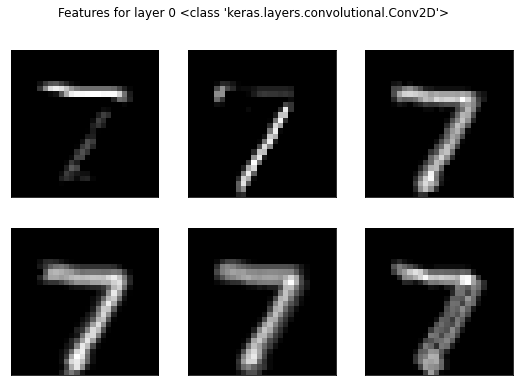

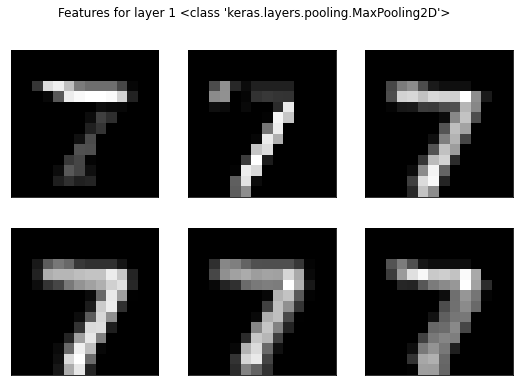

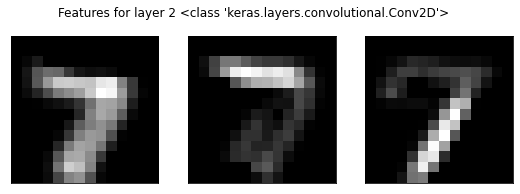

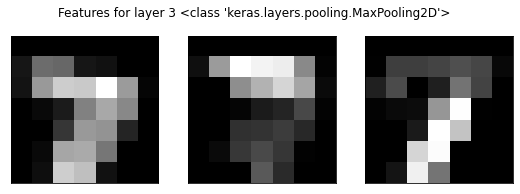

In [19]:
show_feature_maps(model_a, test_images[0:1])



# CIFAR10 image set

- Next try and learn the CIFAR10 image set
- Repeat all of the steps above, but change the dataset_name in the
 top code-block to "cifar10"
- We need a bigger network for CIFAR10 than we did for MNIST.
 Use this architecture:

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
layer1 (Conv2D)              (None, 32, 32, 16)        448
_________________________________________________________________
layer2 (Conv2D)              (None, 32, 32, 32)        4640
_________________________________________________________________
layer3 (MaxPooling2D)        (None, 16, 16, 32)        0
_________________________________________________________________
layer4 (Dropout)             (None, 16, 16, 32)        0
_________________________________________________________________
layer5 (Conv2D)              (None, 16, 16, 64)        18496
_________________________________________________________________
layer6 (Conv2D)              (None, 16, 16, 64)        36928
_________________________________________________________________
layer7 (MaxPooling2D)        (None, 8, 8, 64)          0
_________________________________________________________________
layer8 (Dropout)             (None, 8, 8, 64)          0
_________________________________________________________________
layer9 (Flatten)             (None, 4096)              0
_________________________________________________________________
layer10 (Dense)              (None, 128)               524416
_________________________________________________________________
layer11 (Dense)              (None, 10)                1290
=================================================================
Total params: 586,218
Trainable params: 586,218
Non-trainable params: 0
_________________________________________________________________
```

- For the dropout layers, use a Dropout rate of 0.2
- Train for at least 5 epochs,
 and you should be able to score >60% on the test set for CIFAR10.
- Note that the above architecture is still pretty small
 (particularly, by only having 64 filters).
 But we need this particular smaller architecture,
 so that the auto-marker can handle it comfortably.

Once you have this working, upload your saved model to questions 3+4 of the progress checker.


In [20]:
dataset_name1="cifar10"
accuracy_threshold1 = 0.96  # progress checker expects >96% accuracy on MNIST.
if dataset_name1=="cifar10":
    dataset1 = tf.keras.datasets.cifar10
    class_names1 = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
    # CIFAR10 images are 32*32*3.
    accuracy_threshold1 = 0.6  # progress checker expects >60% accuracy on CIFAR10
elif dataset_name1=="fashion":
    dataset1 = tf.keras.datasets.fashion_mnist
    class_names1 = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
elif dataset_name1=="mnist":
    dataset1 = tf.keras.datasets.mnist
    accuracy_threshold1 = 0.96
    class_names1 = ['zero', 'one', 'two', 'three', 'four','five', 'six', 'seven', 'eight', 'nine']
else:
    print("unknown dataset")
    raise Exception("Please specify a valid dataset!")
(train_images01, train_labels01),(test_images01, test_labels01) = dataset1.load_data()
print('Train: X=%s, y=%s' % (train_images01.shape, train_labels01.shape))
print('Test: X=%s, y=%s' % (test_images01.shape, test_labels01.shape))
train_labels1=train_labels01.reshape(-1)
test_labels1=test_labels01.reshape(-1)


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


## Visualise the Dataset

- Show pictures of the images we are trying to learn...

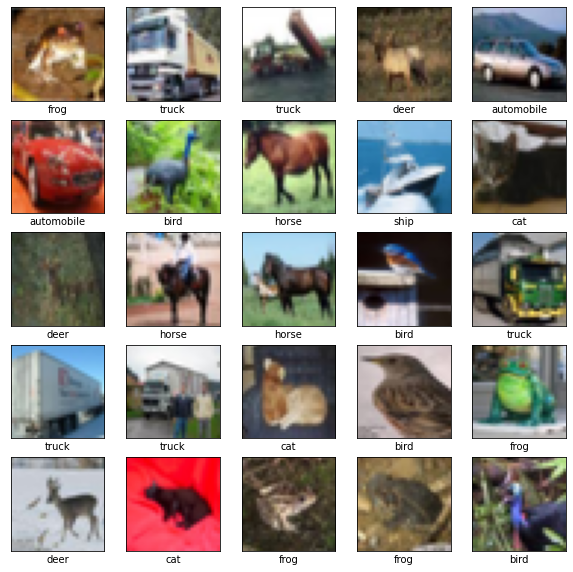

In [21]:
# plot first few images
plt.figure(figsize=(10,10))
for i in range(25):
    # define subplot
    plt.subplot(5,5,i+1)
    # plot raw pixel data
    plt.imshow(train_images01[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if class_names1 is not None:
        # Add a label underneath, if we have one...
        plt.xlabel(class_names1[train_labels1[i]])
plt.show()

## Prep the data
- The keras datasets contain integer pixel intensities from 0 to 255.
  We must rescale this to floats from 0 to 1.

In [22]:
# Rescale greyscale from 8 bit to floating point (by dividing by 255)
test_images1=(test_images01/255.0).astype(np.float32) # 10000 test patterns, shape 10000*28*28
train_images1=(train_images01/255.0).astype(np.float32) # 60000 train patterns, shape 60000*28*28

if len(train_images1.shape)==3:
    # add a single channel to these black-and-white images
    train_images1=train_images1.reshape(list(train_images1.shape)+[1])
    test_images1=test_images1.reshape(list(test_images1.shape)+[1])
    print("Reshaped images from ",train_images01.shape,"to",
          train_images1.shape,"so that 'channel' dimension exists")

num_classification_categories1=train_labels1.max()+1



### defining the cfar10 model

In [23]:
# build FFNN with CNN architecture
keras_model1 = keras.Sequential()
keras_model1.add(
    layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")
)
keras_model1.add(
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")
)
keras_model1.add(
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid")
)
keras_model1.add(
    layers.Dropout(rate=0.2)
)
keras_model1.add(
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")
)
keras_model1.add(
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")
)
keras_model1.add(
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid")
)
keras_model1.add(
    layers.Dropout(rate=0.2)
)
keras_model1.add(layers.Flatten())
keras_model1.add(layers.Dense(128, activation='relu'))
keras_model1.add(layers.Dense(num_classification_categories, activation='softmax'))

## View Model Summary

- have a look at the model summary here.

- Try to verify that the number of parameters of each layer matches what you calculate it should be.

In [24]:
keras_model1.build(input_shape=(None,)+train_images1.shape[1:])
keras_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)         

In [25]:
if keras_model1.count_params()>800000 and dataset_name1=="cifar10":
    print("The lab 7 progress-checker has a 10MB limit on your model size, so please use a smaller model if you want to validate through the auto-marker!")

## Train the network

In [26]:
optimizer1=keras.optimizers.Adam()

keras_model1.compile(optimizer=optimizer1,
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history1 = keras_model1.fit(train_images1, train_labels1,
                batch_size=128,
                epochs=5,
                validation_data=(test_images1, test_labels1))


Epoch 1/5
391/391 [==============================] - 69s 177ms/step - loss: 1.5797 - accuracy: 0.4278 - val_loss: 1.2662 - val_accuracy: 0.5459

## Plot graphs of learning progress...

- Have a look at these graphs, and try to work out whether any overfitting has occurred, or whether we would gain any benefit for training for more or fewer epochs (TODO)

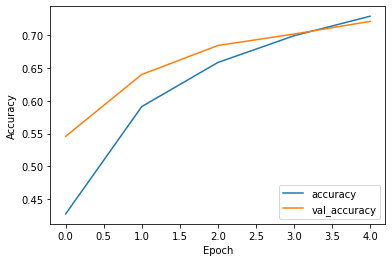

In [27]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')


## Inspect how well the system is working...
- The test set has a lot of images in it, but we can only view 25 at a time.
- Hence rerun this code block several times, to get a different random set of samples from the test set (TODO)


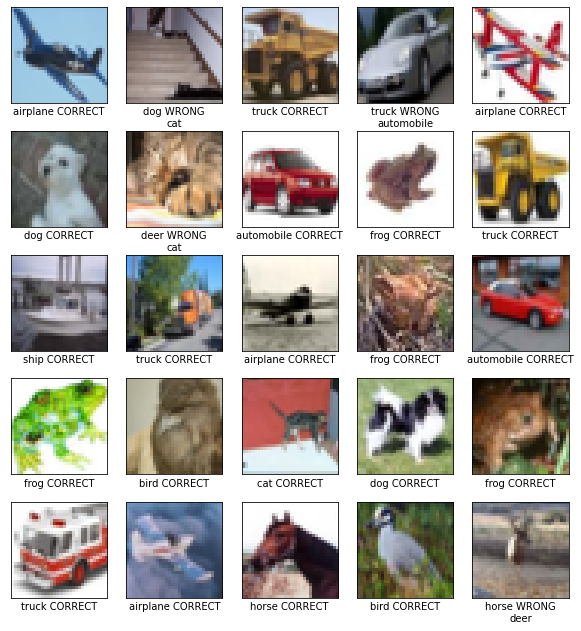

In [28]:

plt.figure(figsize=(10,11))
# plot 25 random images from the test set.
first_index=np.random.randint(len(test_images1)-25)
for i in range(first_index,first_index+25):
    # define subplot
    plt.subplot(5,5,i+1-first_index)
    # plot raw pixel data
    plt.imshow(test_images01[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if class_names is not None:
        # Add a label underneath, if we have one...
        prediction=keras_model1(test_images1[i:i+1])[0,:]
        prediction_class=np.argmax(prediction)
        true_label=test_labels1[i]
        class_name=class_names1[prediction_class]
        plt.xlabel(class_name+" "+("CORRECT" if prediction_class==true_label else "WRONG\n{}".format(class_names1[true_label])))
plt.subplots_adjust(hspace=0.2)
plt.show()

## Save the model
- TODO: Once you have the correct layers created (as described above) and have trained a model which can score >96% on the MNIST digits validation set, save your model with the next code block.
- Then use your saved model as an attachment to pass questions 1+2 of the Lab 9 Progress Checker on Moodle.

In [30]:
if history1.history["val_accuracy"][-1] > accuracy_threshold1:
    print("Your model is accurate enough!")
    # Save the current model into a local folder
    keras.models.save_model(keras_model1, "Model1"+dataset_name1+".h5",save_format='h5')
else:
    print("Accuracy is below the threshold!")
    raise Exception("Your model isn't accurate enough to pass the progress checker!")


Your model is accurate enough!


### Attempts at visualising this model

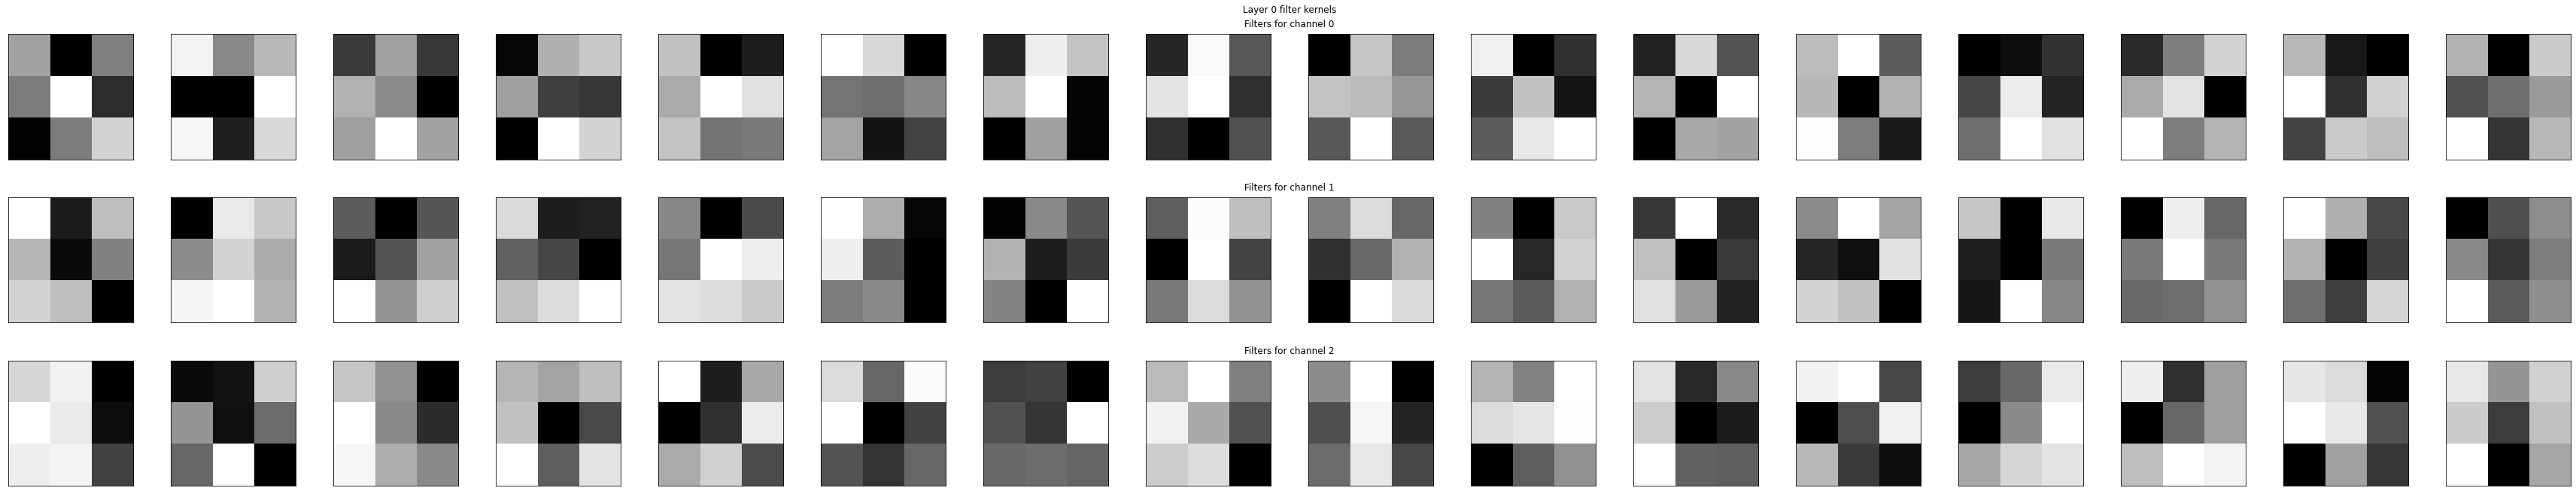

In [31]:
try:
    show_filters_for_layers_auto_title(keras_model1, layers_to_show=[0])
except Exception as e:
    print("cannot show layer 0 filter kernels.")
    print("reason: ")
    print(traceback.format_exc())

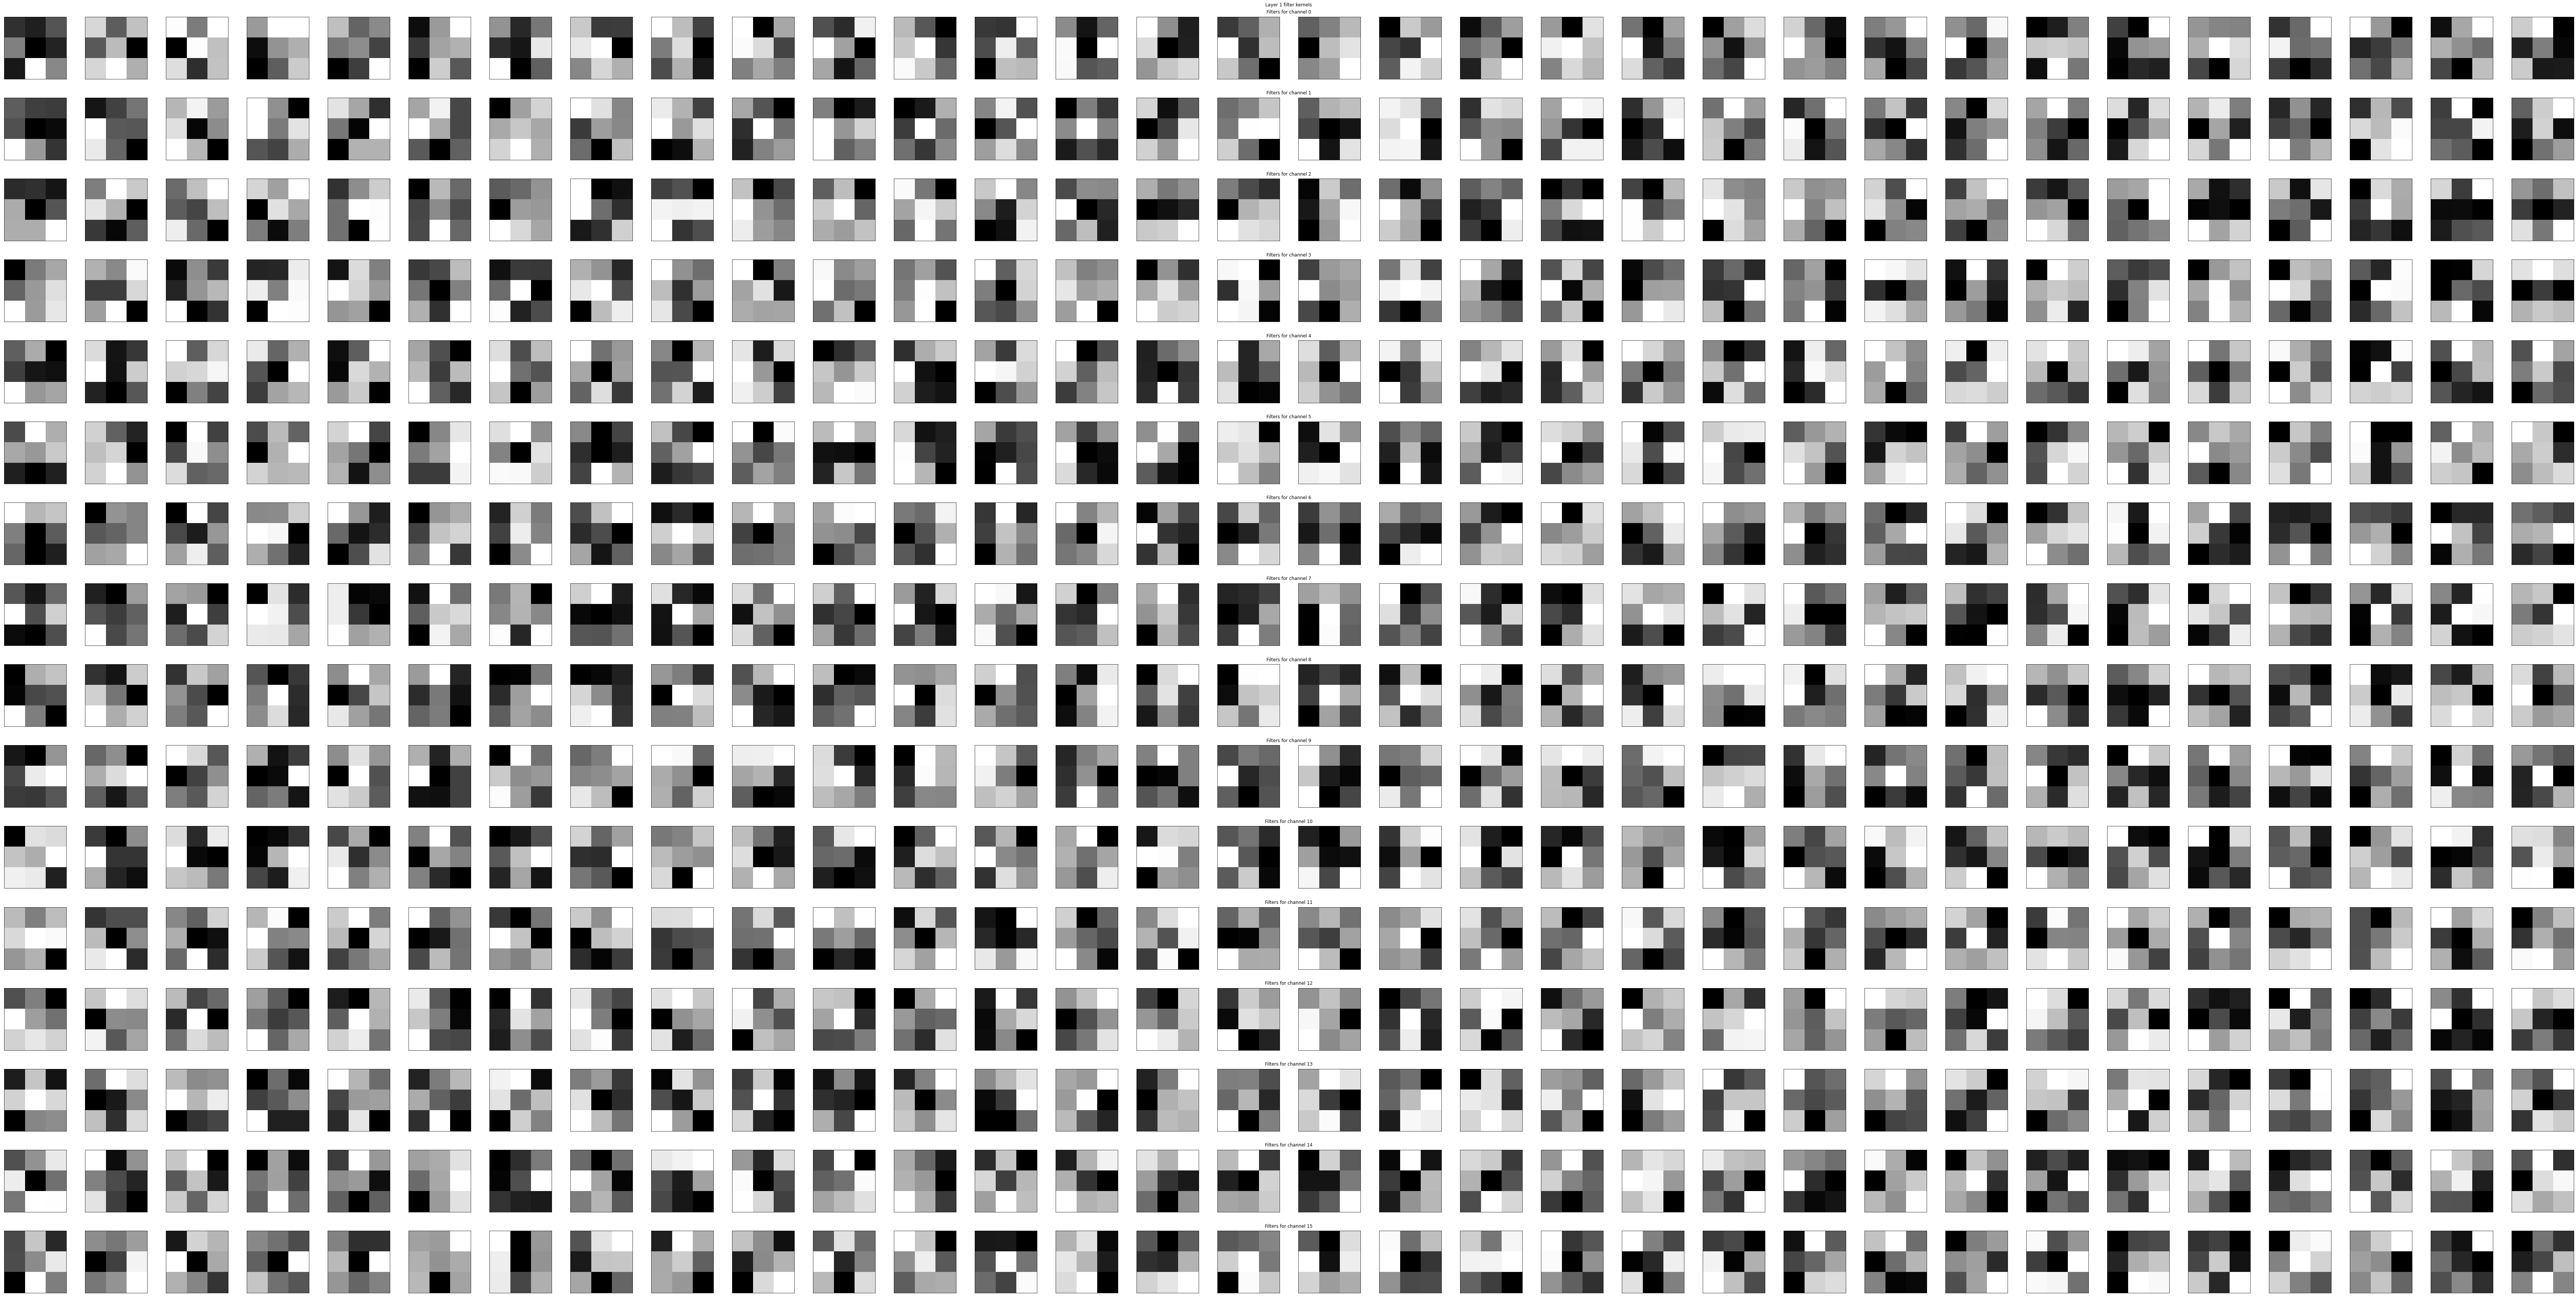

In [32]:
try:
    show_filters_for_layers_auto_title(keras_model1, layers_to_show=[1])
except Exception as e:
    print("cannot show layer 1 filter kernels.")
    print("reason: ")
    print(traceback.format_exc())

In [ ]:

#show_filters_for_layers_auto_title(keras_model1, layers_to_show=[4])

In [ ]:

#show_filters_for_layers_auto_title(keras_model1, layers_to_show=[5])

[]

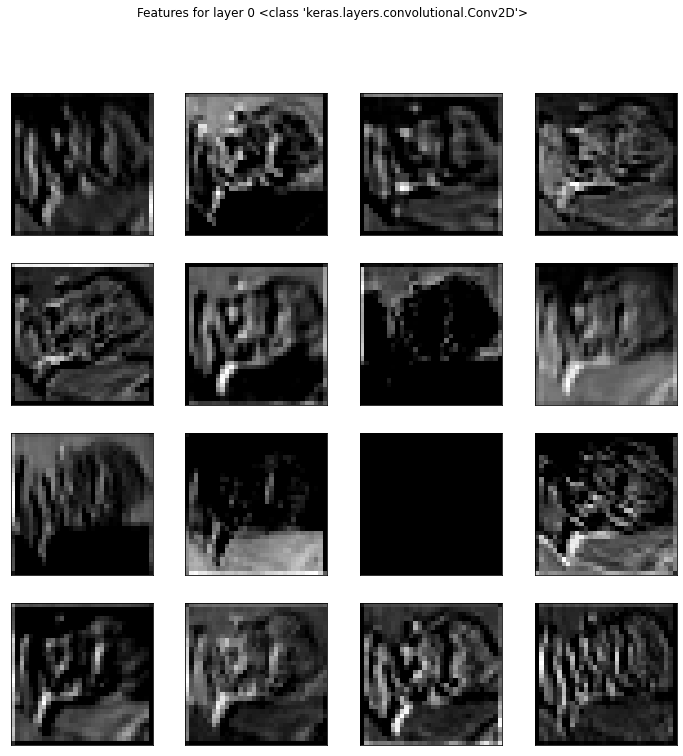

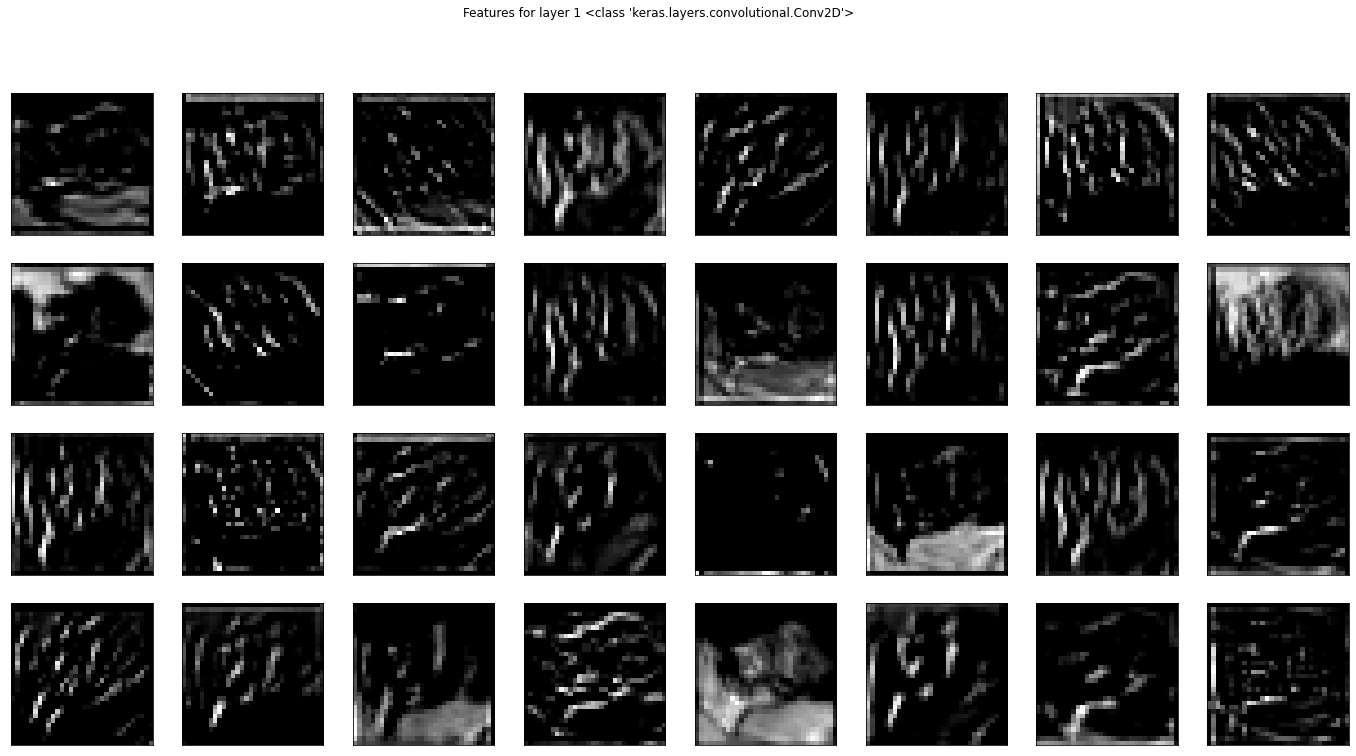

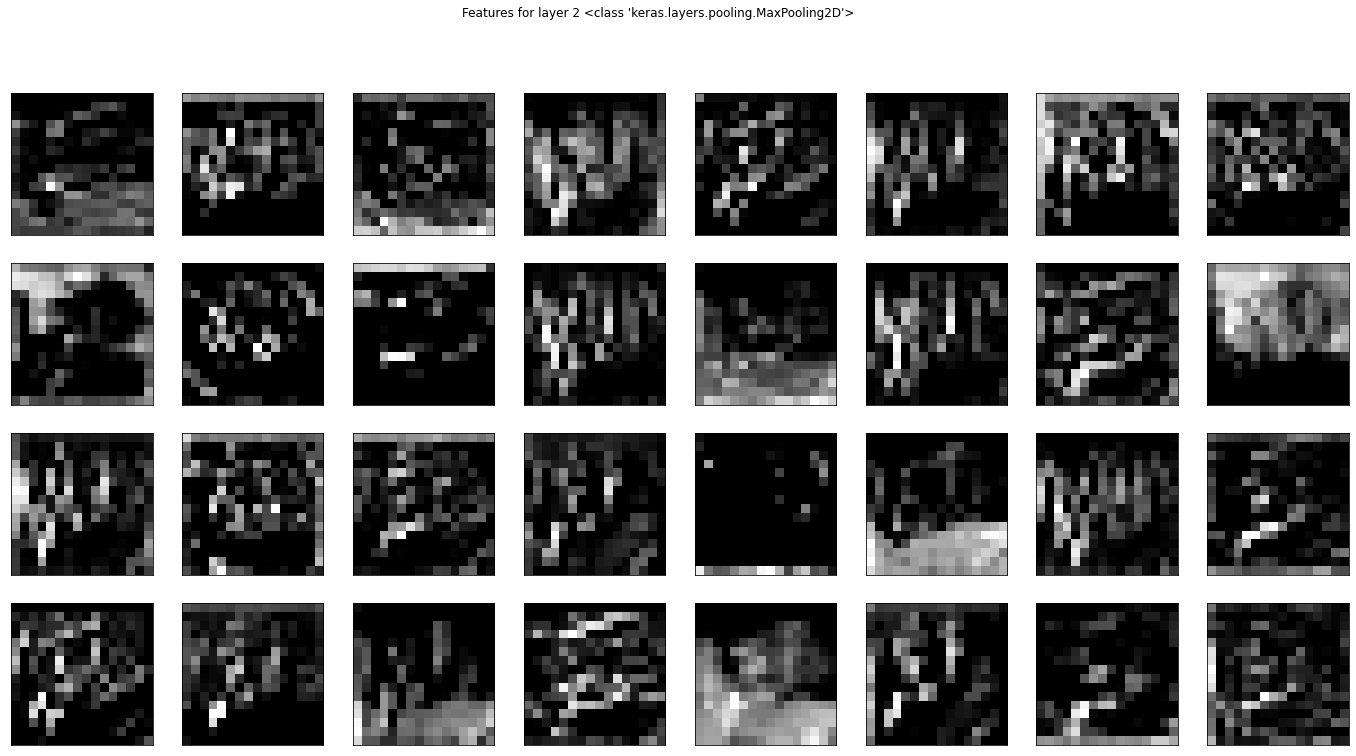

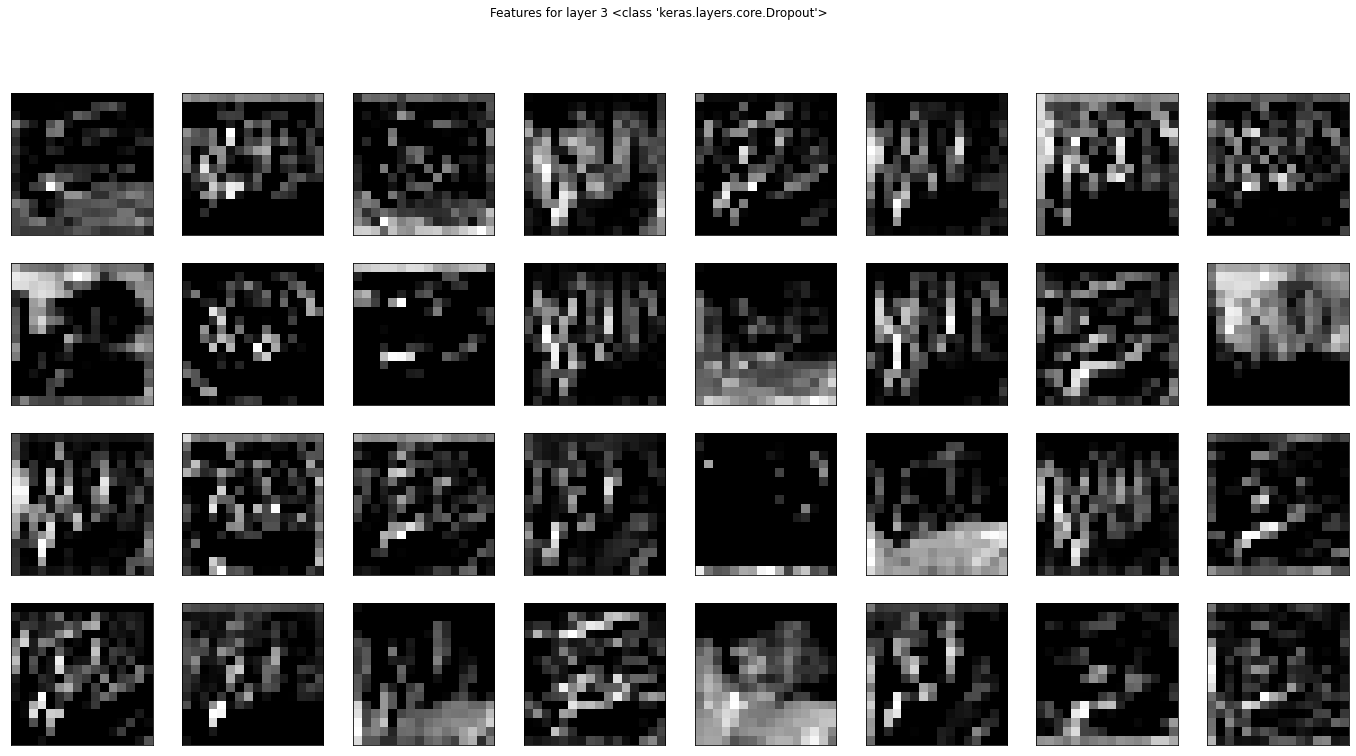

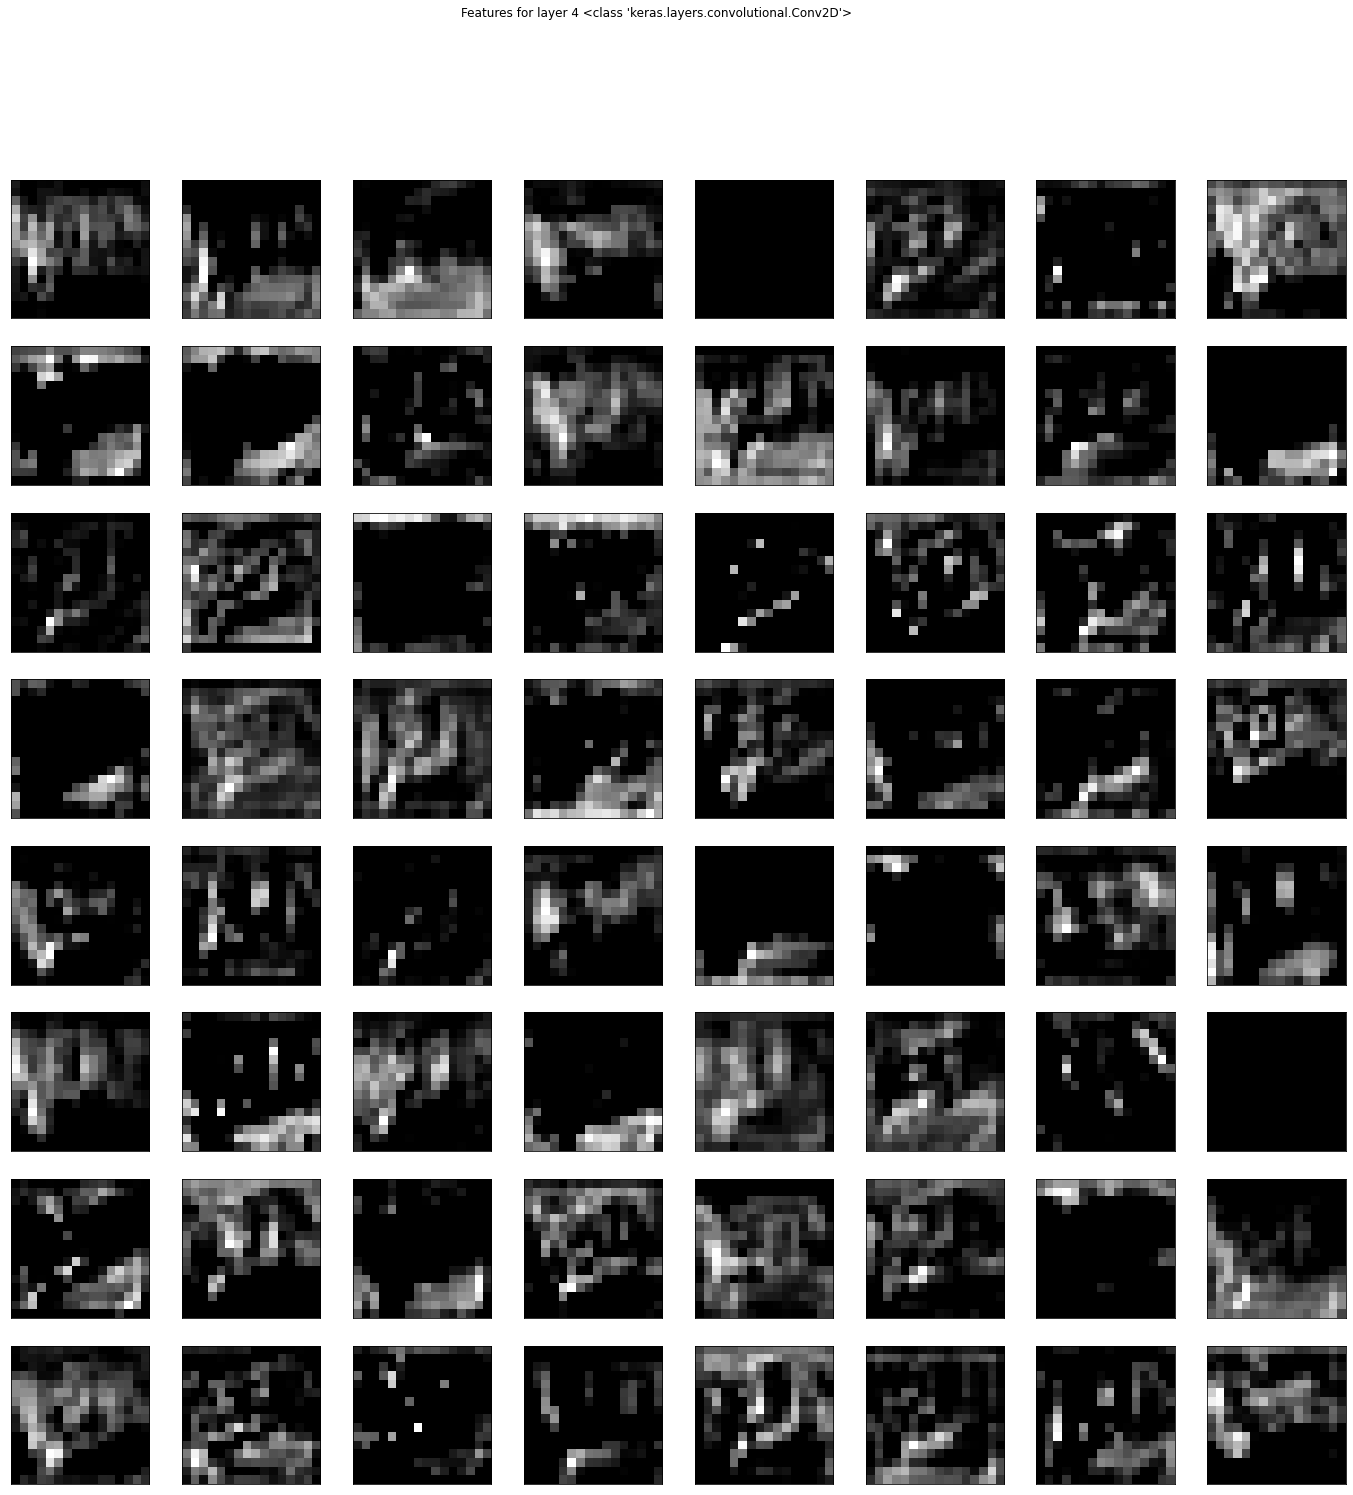

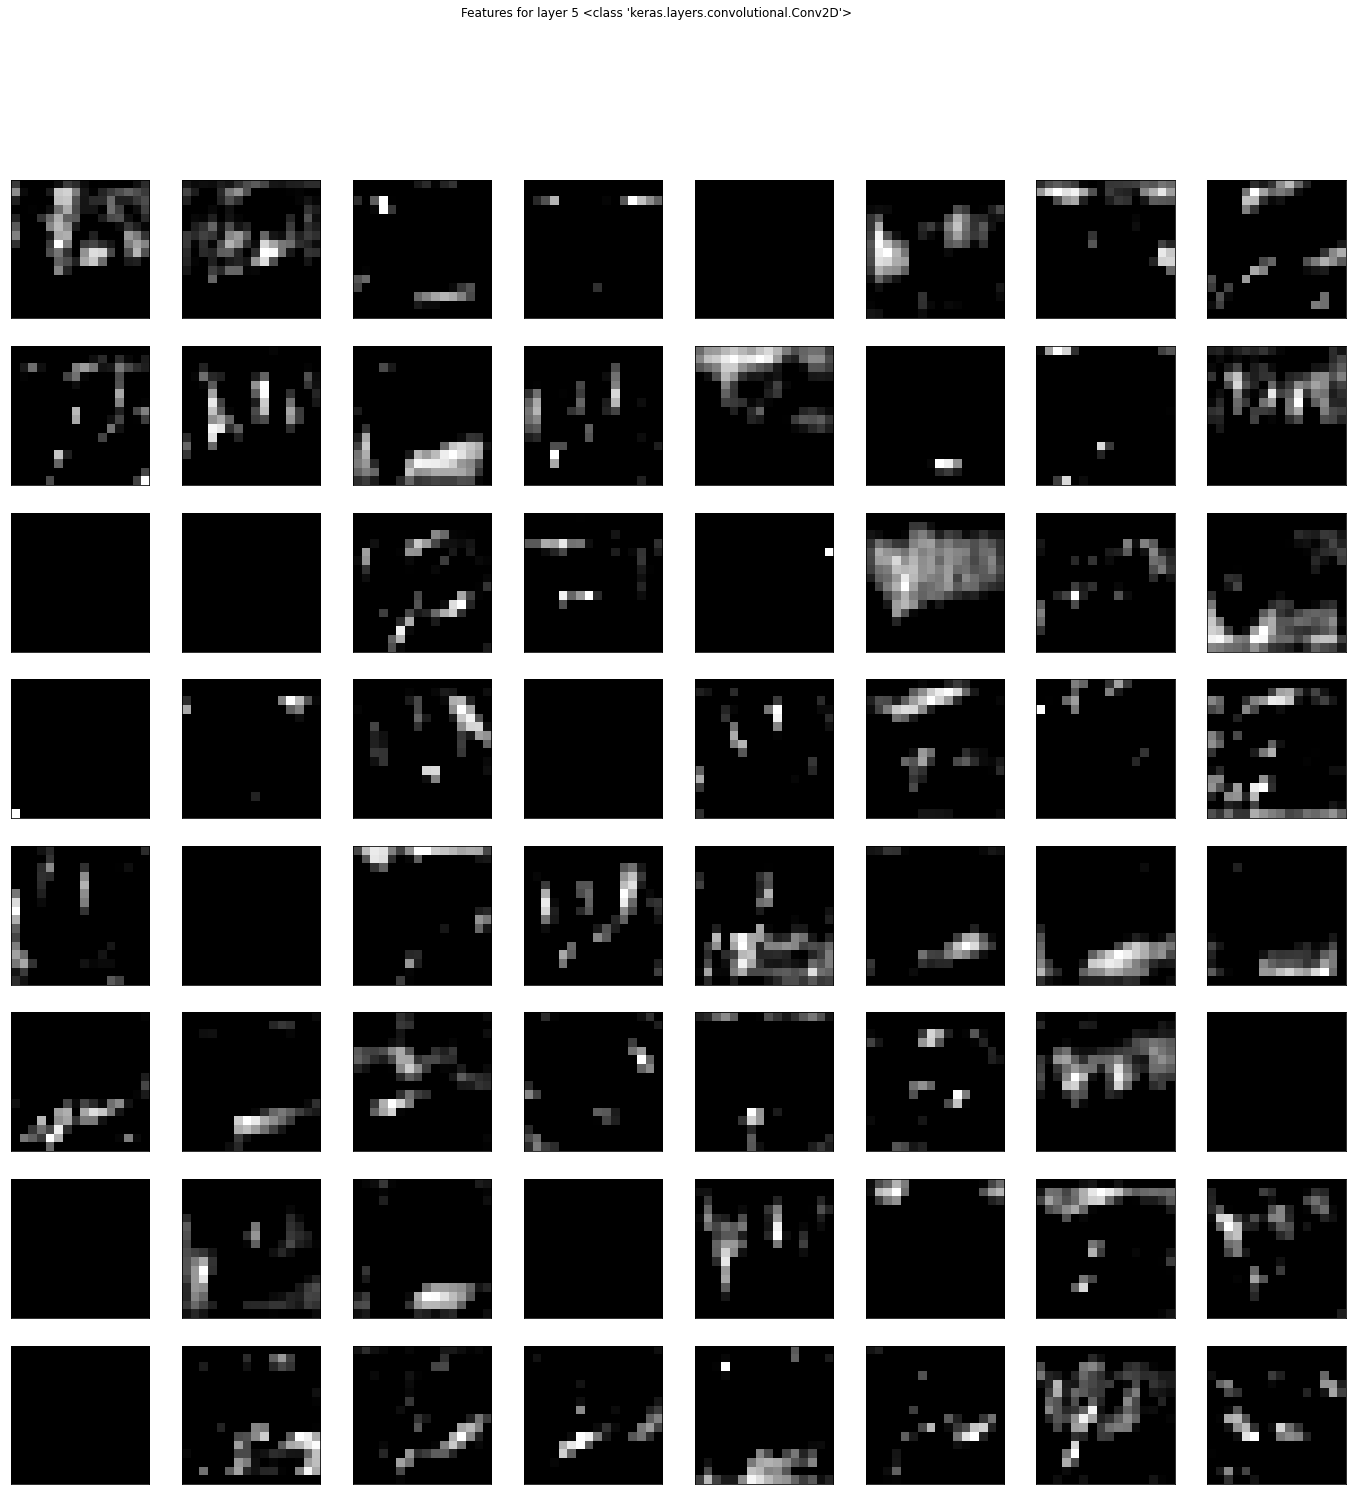

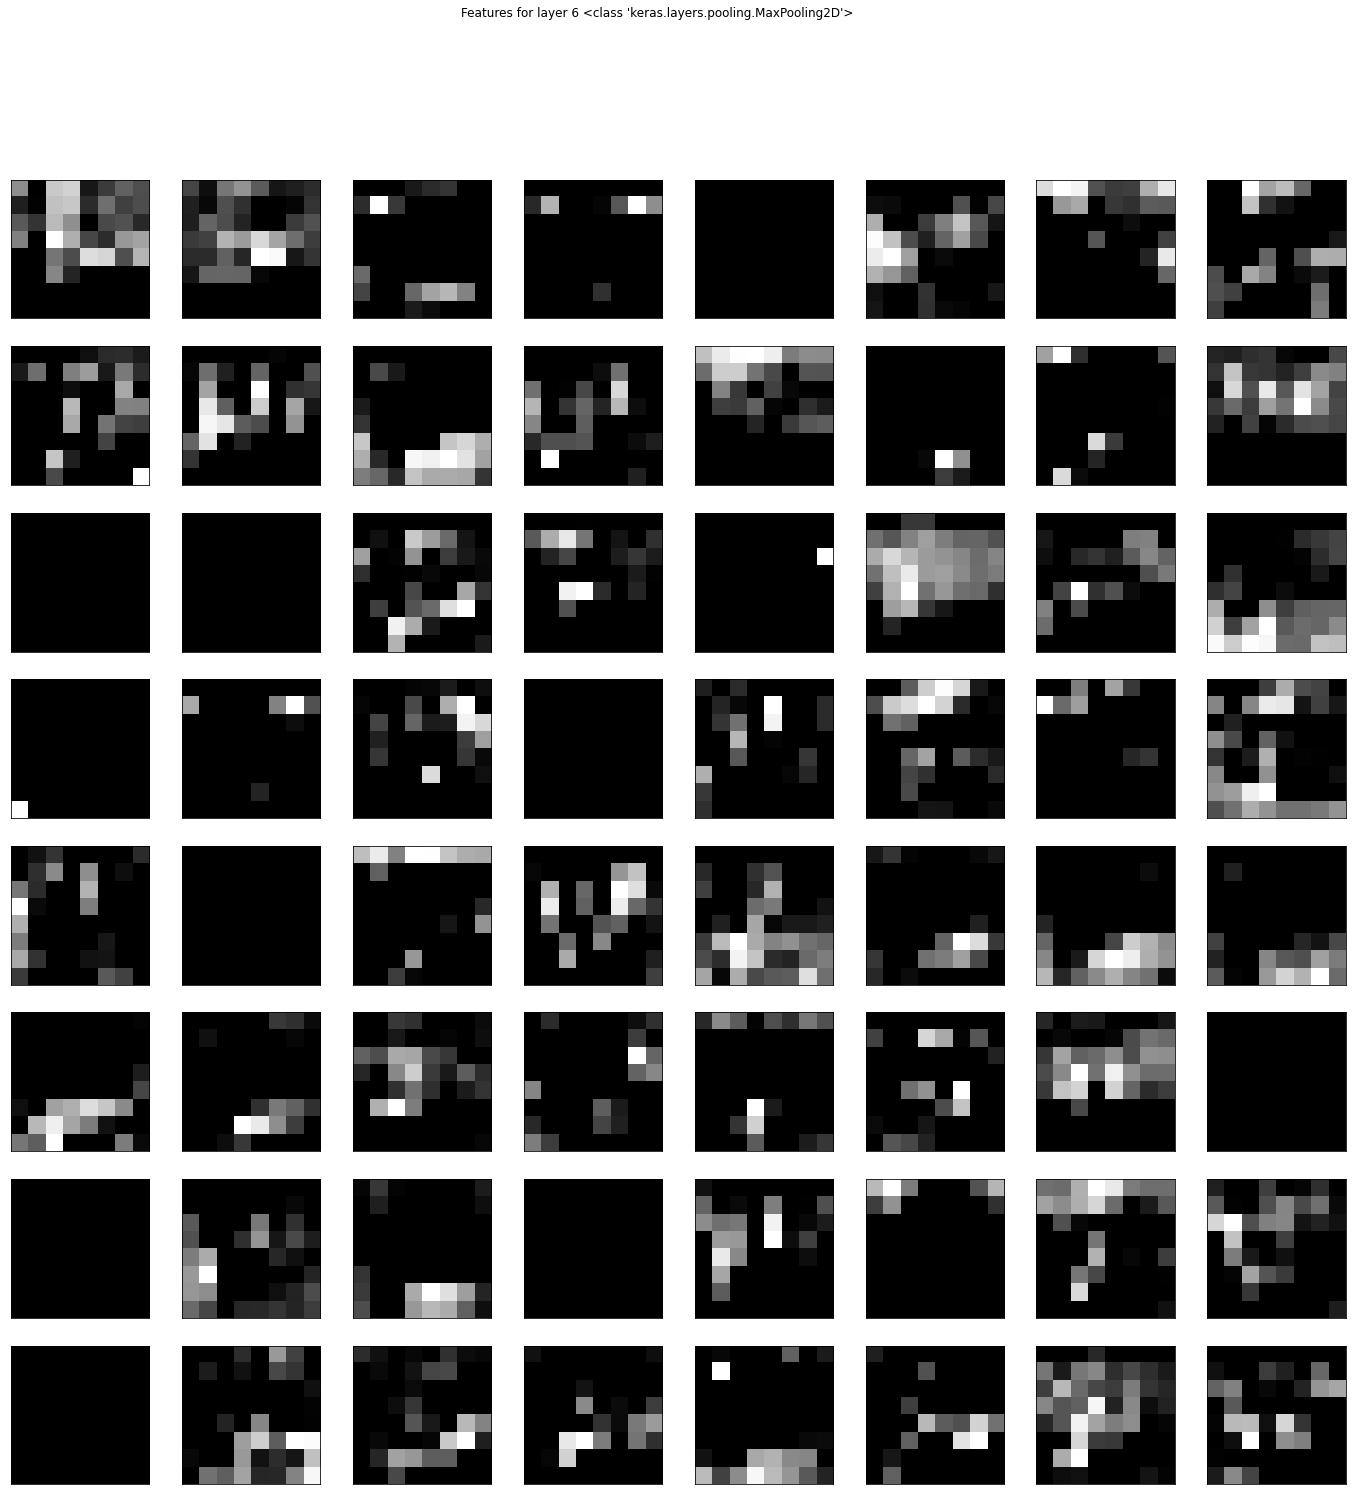

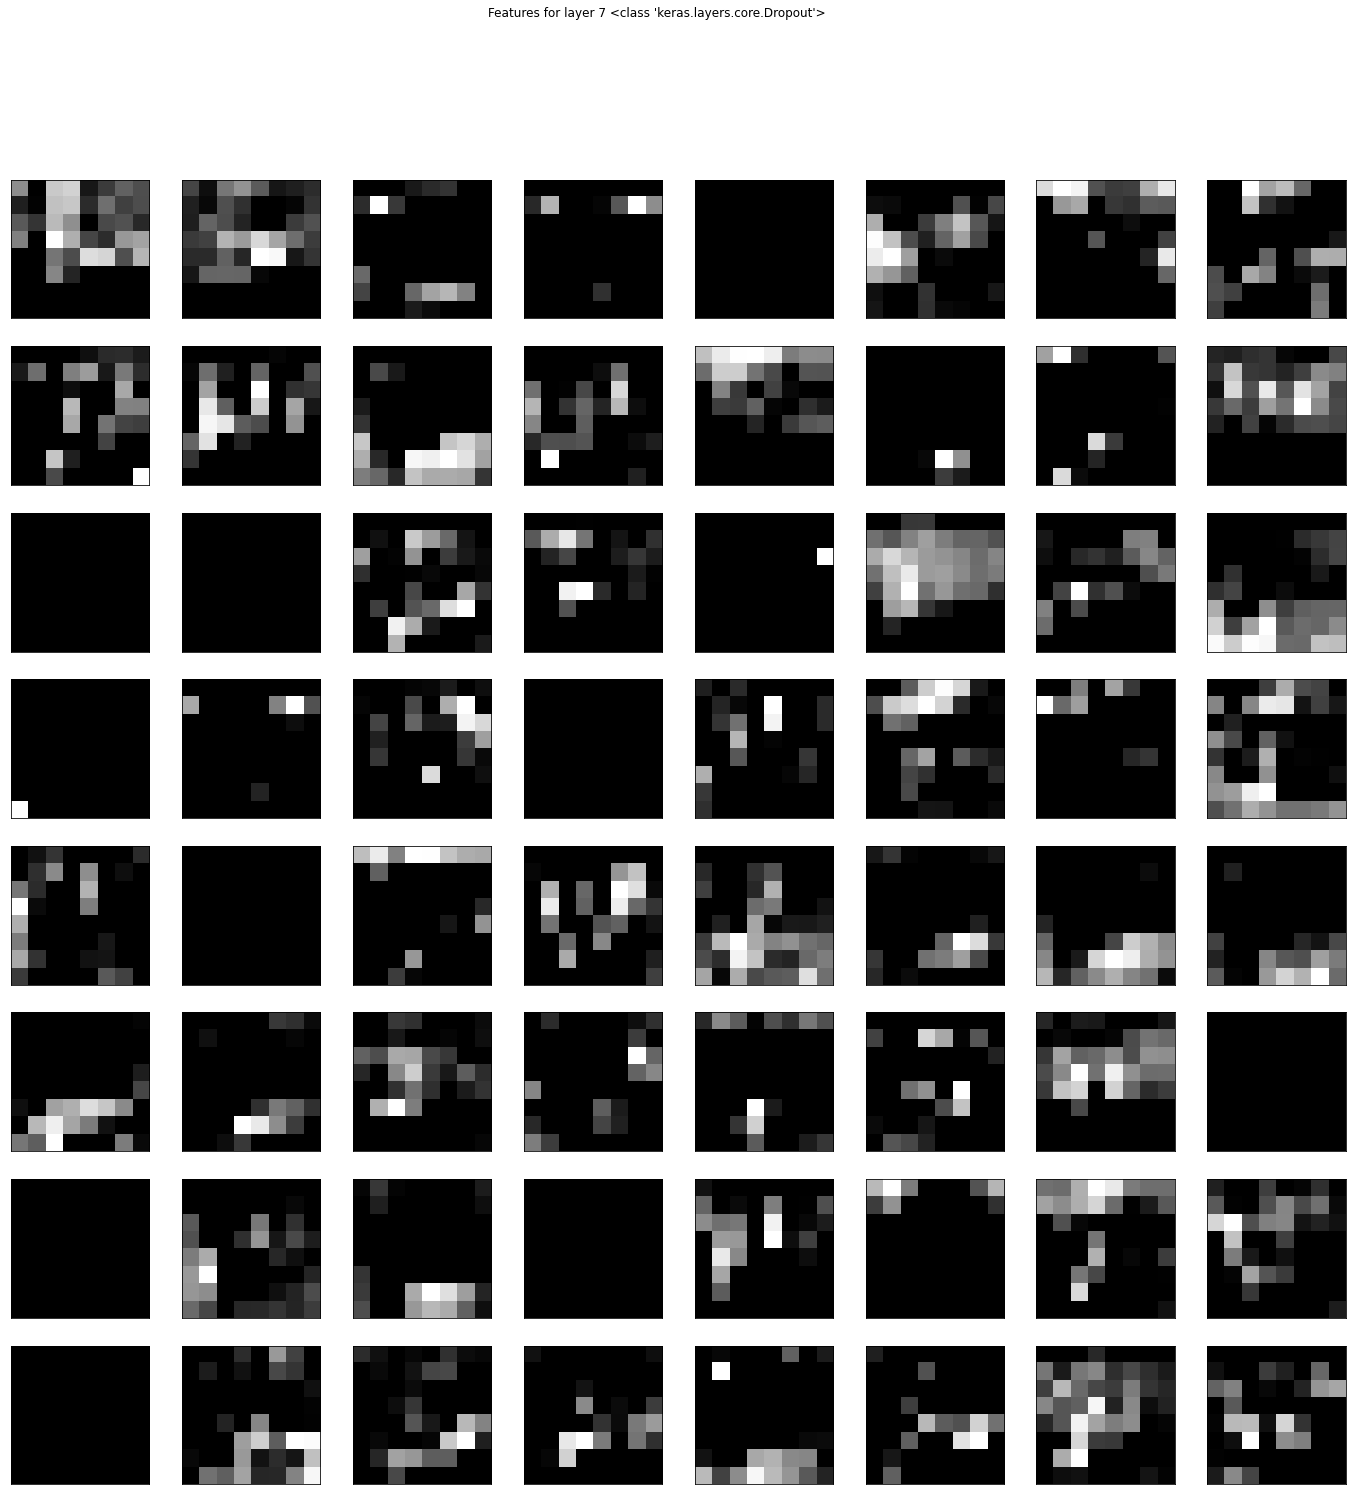

In [33]:

show_feature_maps(keras_model1, test_images1[0:1])




## Checklist of further things to do

Okay you should have completed the progress checker by now.
But if you want to explore further, then...

1. Check you have made 2 different convolutional neural network classifiers, one for MNIST and one for Cifar10.

2. Check that in each case you have inspected the results,
 the validation accuracy and decided whether more or fewer epochs
 would be beneficial.

3. If you have time remaining then see if you can improve performance
 on Cifar10.
    * Possible methods:
        * Try training for longer.
        * Add more convolutional layers.
        * Add more filters at each convolutional layer.
    * Have a look at the CNN structure used here (https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/) to see how you could score >80% on CIFAR10 (see the final architecture at the bottom of the page). However, this requires a lot of CPU/GPU time.

4. If time permits, then see what the effect of changing the relu activation functions to tanh.

